## Mridangam tonic classification task using Essentia Music Extractor.

In this notebook I experimented a little with ML and Neural Networks in the classification of sounds by its tonic.

In [1]:
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install mirdata
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support MIR
import mirdata
import essentia.standard as ess
import pandas as pd


## Data processing

We initialize Mridangam stroke a collection of 7162 audio examples of individual strokes of the Mridangam in various tonics. The dataset comprises of 10 different strokes played on Mridangams with 6 different tonic values. 

In this experiment we predict 6 tonic classes. 

In [3]:
mridangam = mirdata.initialize("mridangam_stroke")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#This cell downloads and validates the mridangam dataset
mridangam.download()  # download the dataset

124MB [03:43, 583kB/s]                           


In [ ]:
mridangam.validate()  # validate that all the expected files are there

100%|██████████| 6976/6976 [00:01<00:00, 6891.59it/s]


({'tracks': {}}, {'tracks': {}})

In [5]:
mridangam_ids = mridangam.track_ids  # Load Mridangam IDs
mridangam_data = mridangam.load_tracks()  # Load Mridangam data

mridangam_data[mridangam_ids[0]]  # Visualize a single track

Track(
  audio_path="/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224030__akshaylaya__bheem-b-001.wav",
  stroke_name="bheem",
  tonic="B",
  track_id="224030",
  audio: The track's audio

        Returns,
)

In [6]:
# Get a list of the different strokes
tonic_names = []
for i in mridangam_ids:
    tonic_names.append(mridangam_data[i].tonic)
tonic_names = np.unique(tonic_names)

print(tonic_names)

['B' 'C' 'C#' 'D' 'D#' 'E']


In [7]:
# Create a dictionary using stroke type as keys
tonic_dict = {item: [] for item in tonic_names}
for i in mridangam_ids:
    tonic_dict[mridangam_data[i].tonic].append(mridangam_data[i].audio_path)

tonic_dict['B']

['/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224030__akshaylaya__bheem-b-001.wav',
 '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224031__akshaylaya__bheem-b-002.wav',
 '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224032__akshaylaya__bheem-b-003.wav',
 '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224033__akshaylaya__bheem-b-004.wav',
 '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224034__akshaylaya__bheem-b-005.wav',
 '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224035__akshaylaya__cha-b-001.wav',
 '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224036__akshaylaya__cha-b-002.wav',
 '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224037__akshaylaya__cha-b-003.wav',
 '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224038__akshaylaya__cha-b-004.wav',
 '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224039__akshaylaya__cha-b-005.wav',
 '/root/mir_datasets

Plot waveforms of random samples of each tonic type...


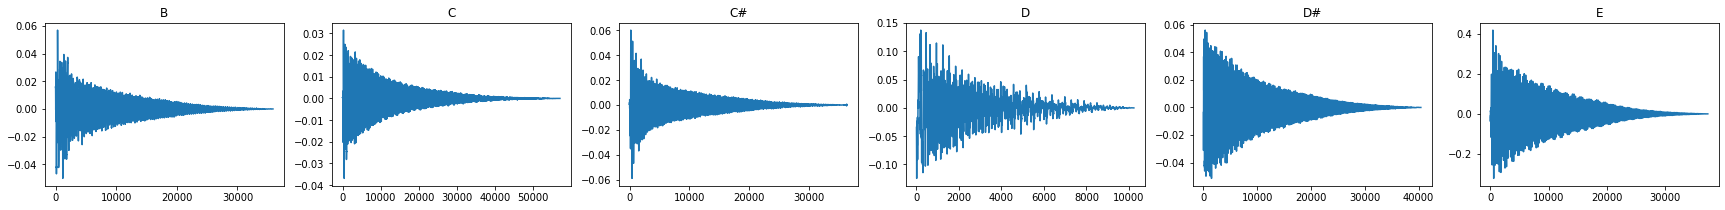

In [8]:
# Raw-data preprocess analysis parameters
_, fs = mridangam_data[mridangam_ids[0]].audio

num_tonic = len(tonic_dict.keys())
print("Plot waveforms of random samples of each tonic type...")
plt.figure(1, figsize=(5 * num_tonic, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, tonic in enumerate(tonic_dict.keys()):
    sample_file = tonic_dict[tonic][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_tonic,(i+1))
    plt.plot(x)
    plt.title(tonic)

## Preprocessing of raw data: Segmentation, splitting, alignment,... 

While common preprocessing steps (such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning, and format change. 

In the downloaded dataset, recordings include a sequence of isolated notes played in sequence which could be split into isolated notes. We would like to investigate the option of splitting using a fixed energy threshold (which would help us separate notes using the silence regions). Let's define a function to perform this operation and visualize some samples to observe the effectiveness of it.

In [9]:
# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.005 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [10]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Here we can observe the implementation of the function defined below in order to identify different regions on the waveforms according to its energy and be able to split them based on their energy threshold.

Sample plots for waveform versus energy and splits based on energy threshold


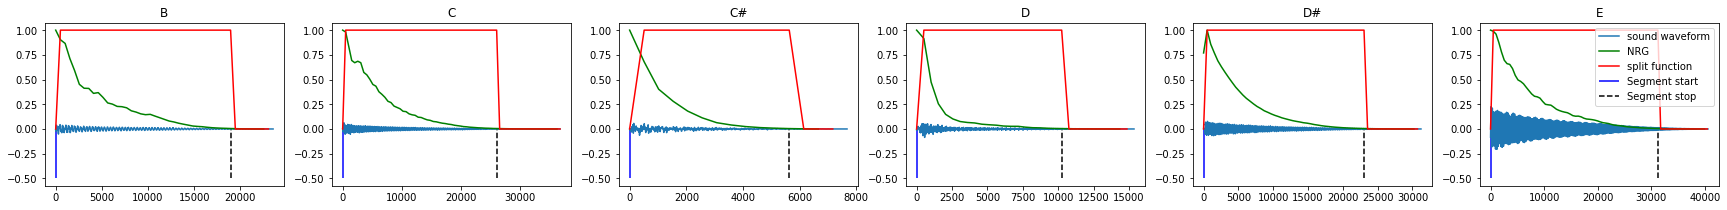

In [11]:
num_tonic = len(tonic_names)
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [1]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_tonic, 3))
    for i, tonic in enumerate(tonic_dict.keys()):
        sample_file = tonic_dict[tonic][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(1,num_tonic,(i+1))
        plt.title(tonic)
        plt.plot(x, label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");


In [12]:
main_data_dir = 'sample_data_tonic'
if not os.path.exists(main_data_dir): #creating the directory
    os.mkdir(main_data_dir)
segments_dir = os.path.join(main_data_dir,'segments_tonic')
if not os.path.exists(segments_dir): #creating the directory
    os.mkdir(segments_dir)

segment_files = []
for tonic, files in tonic_dict.items():
    for sample_file in files:
        #Get file id
        tonic_id =  sample_file.split('__')[-1].split('.')[0]
        x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Croping segments
        for start, stop in zip(start_indexes, stop_indexes):
            x_seg = x[start: stop]
            #Final check for amplitude (to avoid silent segments selection due to noise in split function)
            if(np.max(np.abs(x_seg)) > 0.05):
                #Amplitude normalisation
                x_seg = x_seg / np.max(np.abs(x_seg))
                filename = os.path.join(segments_dir, tonic_id + '.wav')
                ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
                segment_files.append(filename)

print(len(segment_files),'segment files created')

6854 segment files created


In [ ]:
#If required, you can use this cell to delete all files in a given folder
def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

#delete_files_in_dir(segments_dir)

## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [13]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(mridangam_data['224030'].audio_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [ ]:
# Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = 'sample_data_tonic/data.csv'
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['tonic']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for filename in segment_files:
        file_count +=1
        if file_count % 20 == 0: #print name of a file every 20 files
            print(file_count, "files processed, current file: ", filename)

        #Compute and write features for file
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(filename)
        selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
        label = filename.split('/')[-1].split('.')[0].split('-')[1]
        line2write = str(selected_features)[1:-1] + ',' + label + '\n'
        writer.write(line2write)
print("A total of ", file_count, "files processed")

20 files processed, current file:  sample_data_tonic/segments_tonic/cha-b-017.wav
40 files processed, current file:  sample_data_tonic/segments_tonic/cha-b-039.wav
60 files processed, current file:  sample_data_tonic/segments_tonic/dheem-b-005.wav
80 files processed, current file:  sample_data_tonic/segments_tonic/dheem-b-026.wav
100 files processed, current file:  sample_data_tonic/segments_tonic/dheem-b-046.wav
120 files processed, current file:  sample_data_tonic/segments_tonic/dheem-b-066.wav
140 files processed, current file:  sample_data_tonic/segments_tonic/dheem-b-095.wav
160 files processed, current file:  sample_data_tonic/segments_tonic/dheem-b-116.wav
180 files processed, current file:  sample_data_tonic/segments_tonic/dhin-b-012.wav
200 files processed, current file:  sample_data_tonic/segments_tonic/dhin-b-040.wav
220 files processed, current file:  sample_data_tonic/segments_tonic/num-b-013.wav
240 files processed, current file:  sample_data_tonic/segments_tonic/num-b-03

In [15]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,tonic
0,0.990684,15.045286,1.854457,0.372195,0.078171,155.698425,116.191475,7.763120,2.870029,1.459613,...,104.330238,4.505210,0.720354,3449997.25,2149744.25,0.623849,0.403493,0.008395,0.002812,b
1,0.990684,14.898280,2.280415,0.391228,0.083327,133.322464,80.732315,6.428464,1.788766,1.242456,...,54.856857,5.026468,0.800210,3145256.00,2228093.25,0.763095,0.469566,0.006445,0.001386,b
2,0.990684,14.472402,2.531276,0.355560,0.088243,104.285118,69.695938,5.909654,2.103197,1.706020,...,67.465721,4.368255,0.802401,4535478.50,5375153.00,0.743537,0.436122,0.005964,0.001557,b
3,0.990684,15.161849,1.408289,0.372373,0.072589,196.814804,126.745834,8.861809,3.526606,1.458768,...,93.040909,4.677685,0.927602,3632668.25,3444228.00,0.574670,0.406087,0.008301,0.001870,b
4,0.990684,9.315184,1.707345,0.149848,0.008073,1.450477,1.422889,1.010031,0.392941,13.218195,...,186.405289,2.912083,0.371276,5415187.00,4073531.50,0.562442,0.492694,0.031494,0.012608,b


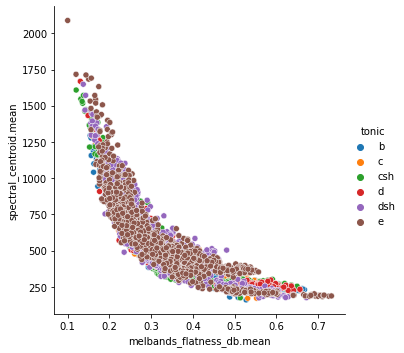

In [16]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "tonic", data = data);

### Preprocessing of the features


In [17]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [18]:
# Checking if our data is balanced (if not, we should balance it to prevent our model to be baised)
data_modif.tonic.value_counts()

dsh    1456
b      1271
e      1097
csh    1086
c      1079
d       865
Name: tonic, dtype: int64

In [19]:
# Here we didn't pick the lowest number, 865 for d. Instead, we choose the 1079 of "c"
min_number = data_modif.tonic.value_counts()['c']
dsh_data = data_modif[data_modif.tonic == 'dsh'].sample(n = min_number, random_state = 42)
b_data = data_modif[data_modif.tonic == 'b'].sample(n = min_number)
e_data = data_modif[data_modif.tonic == 'e'].sample(n = min_number)
csh_data = data_modif[data_modif.tonic == 'csh'].sample(n = min_number)
c_data = data_modif[data_modif.tonic == 'c'].sample(n = min_number)
d_data = data_modif[data_modif.tonic == 'd']

#Merging after downsampling
data_modif = pd.concat([dsh_data, b_data, e_data, csh_data, c_data, d_data])
#Checking the balance again
data_modif.tonic.value_counts()

dsh    1079
b      1079
e      1079
csh    1079
c      1079
d       865
Name: tonic, dtype: int64

## Supervised learning approach (Support Vector Machines)

In [20]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
# Creating output values
data_modif.tonic = pd.Categorical(data_modif.tonic)  # convert to categorical data
y = np.array(data_modif.tonic.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [0.         0.34395326 0.17931018 0.18435474 0.1874001  0.0090178
 0.00245021 0.13056983 0.04162913 0.20924967 0.1365113  0.65480577
 0.33498929 0.         0.51752667 0.25587586 0.36437642 0.15023524
 0.04231653 0.00664512 0.35272015 0.07894686 0.20386521 0.04747439
 0.80246869 0.76530441 0.25316711 0.         0.25316711 0.
 0.21576821 0.         0.46881728 0.32290411 0.1482361  0.17248696
 0.08040183 0.07609955 0.31516544 0.41228163 0.23317294 0.21932166
 0.68851102 0.48525399 0.         0.         1.         0.
 0.42857143 0.94280899 0.52656728 0.2916527  0.52156412 0.4011237
 0.51571577 0.45158409 0.54424633 0.49911383 0.24376695 0.19798659
 0.01021586 0.01090169 0.9517451  1.         0.12666579 0.11095656
 0.88301174 0.18245918 0.69124145 0.69811412 0.01277032 0.01152732
 0.54550447 0.64212103 0.39834822 0.09445676 0.06743958 0.07878628
 0.48842782 0.34750155 0.60791909 0.30991713 0.55042736 0.43968719]
Class of the first sample:  4


In [21]:
# Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (4194, 84) , Size of train output vector:  (4194,)
Size of test features matrix:  (2066, 84) , Size of test output vector:  (2066,)


In [22]:
# Define and train the model

from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

In [23]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([ True, False, False, ...,  True,  True,  True])

In [24]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.6243949661181026


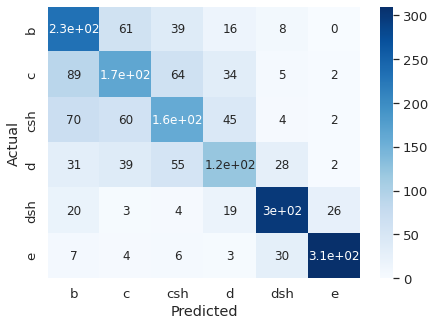

In [25]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.tonic)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

We can observe that the results are pretty good, specially in the case of E, D sharp and B. Maybe with other ML techniques or even Neural Networks the results may be better, so we will try in the next steps.

## Decision trees with SKLearn

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics

In [36]:
X = data_modif.drop(['tonic'], axis = 1) # separa las entradas en x
y = data_modif['tonic'] # deja para y las salidas (un único vector, 1 dimensión)
print('Dimension of X:', X.shape)
print('Dimension of Y:', y.shape)

Dimension of X: (6260, 84)
Dimension of Y: (6260,)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

After trying different criterions, depths and samples split values, I choose this combination as it gives better results while being efficient.

In [38]:
DT_classifier = DecisionTreeClassifier(criterion= 'gini', max_depth= 25, min_samples_split= 15) 

In [39]:
DT_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=25, min_samples_split=15)

In [40]:
y_pred = DT_classifier.predict(X_test)

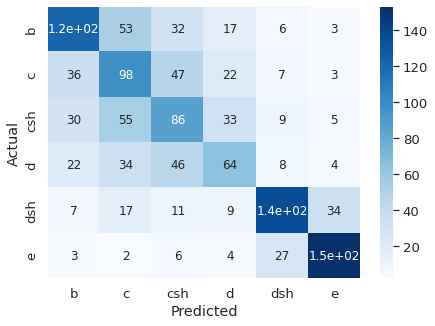

In [41]:
classes = np.unique(data_modif.tonic)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

In [42]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           b       0.55      0.52      0.54       233
           c       0.38      0.46      0.42       213
         csh       0.38      0.39      0.39       218
           d       0.43      0.36      0.39       178
         dsh       0.71      0.64      0.67       215
           e       0.76      0.78      0.77       195

    accuracy                           0.53      1252
   macro avg       0.53      0.53      0.53      1252
weighted avg       0.53      0.53      0.53      1252



We can observe that specially for D sharp and E (71%, 76%), the decision tree precision is high, being its overall accuracy around 53%

## Supervised learning approach (Neural Network)

In [26]:
from sklearn.preprocessing import StandardScaler

# Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# ..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [27]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (5008, 6)
One-hot encoded y_test shape =  (1252, 6)


In [28]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 6))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_val.shape[1])

In [29]:
model.summary()  # Plot summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormalizat  (None, 84)               336       
 ion)                                                            
                                                                 
 HiddenLayer_1 (Dense)       (None, 40)                3400      
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40)                0         
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 20)                8

In [32]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0)

In [33]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20452885329723358
Test accuracy: 0.7172523736953735


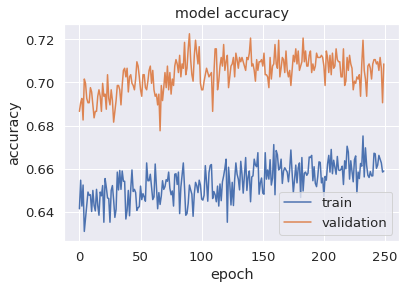

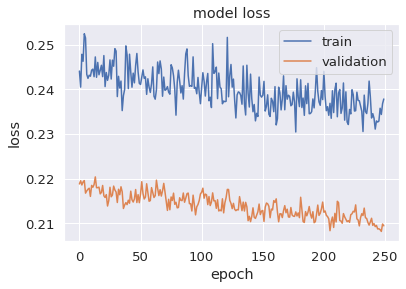

In [34]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

After tying different Neural Network coombinations, the best one I could train (given my experience in the field) is this one.

As we can see, its overall accuracy (71,7%) is better than the one we obtained for the ML models, but it also may be better.

As we can observe, overall, in this model and for these variables, it's easier for the models to predict E, D sharp and B. The accuracy for these variables pretty good, while the other 3 have a lower accuracy.